In [43]:
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from functools import reduce
import operator
import random
import traceback
import abc
import pickle
from tensorflow.keras.optimizers import Adam
import gym
import gc
from PIL import Image

# Atari shit

In [2]:
#mount drive and indexing
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir Atari

In [4]:
pip install rarfile

In [5]:
import rarfile     
file_path = "/content/drive/MyDrive/DOT/Roms.rar" 
extract_to_path = "/content/Atari"
rf = rarfile.RarFile(file_path)
rf.extractall(extract_to_path)

In [6]:
! python -m atari_py.import_roms /content/Atari

copying assault.bin from /content/Atari/HC ROMS/NTSC VERSIONS OF PAL ORIGINALS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying king_kong.bin from /content/Atari/HC ROMS/BY ALPHABET (PAL)/H-R/King Kong (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/king_kong.bin
copying mr_do.bin from /content/Atari/HC ROMS/BY ALPHABET (PAL)/H-R/Mr. Do! (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/mr_do.bin
copying keystone_kapers.bin from /content/Atari/HC ROMS/BY ALPHABET (PAL)/H-R/Keystone Kapers (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/keystone_kapers.bin
copying laser_gates.bin from /content/Atari/HC ROMS/BY ALPHABET (PAL)/H-R/Laser Gates (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/laser_gates.bin
copying pacman.bin from /content/Atari/HC ROMS/BY ALPHABET (PAL)/H-R/Pac-Man (PAL).bin to /usr/local/l

# Code

In [7]:
class SegmentTree():
    def __init__(self, capacity, operation, neutral_element):
        assert capacity > 0 and capacity & (capacity - 1) == 0, 'capacity must me a positive power of 2'
        self.capacity = capacity
        self.operation = operation
        self.neutral_element = neutral_element
        self.memory = np.full(2 * self.capacity, self.neutral_element)
    
    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self.memory[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )
    
    def reduce(self, start=0, end=0):
        if end < 0:
            end += self.capacity - 1
        return self._reduce_helper(start, end, 1, 0, self.capacity - 1)
    
    def __setitem__(self, idx, val):
        idx += self.capacity
        self.memory[idx] = val

        idx //= 2
        while idx >= 1:
            self.memory[idx] = self.operation(self.memory[2 * idx], self.memory[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self.capacity
        return self.memory[self.capacity + idx]

class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, neutral_element=0.0)

    def sum(self, start=0, end=0):
        return super(SumSegmentTree, self).reduce(start, end)

    def retrieve(self, upperbound):
        idx = 1

        while idx < self.capacity:
            left = 2 * idx
            right = left + 1
            if self.memory[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.memory[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, neutral_element=float("inf"))

    def min(self, start=0, end=0):
        return super(MinSegmentTree, self).reduce(start, end)

In [8]:
class PrioritizedReplayBuffer():
    def __init__(self, size, shape, actions, alpha):
        assert size > 0 and size & (size - 1) == 0, 'size must me a positive power of 2'
        self.size = size

        assert shape is not None, 'shape must not be None'
        self.shape = shape

        #assert actions > 0, 'actions must me greater than 0'
        self.actions = actions

        assert 0 <= alpha <= 1, 'alpha must me between 0 and 1 (0: no prioritization, 1: full prioritization)'
        self.alpha = alpha
        self.max_priority = 1.0
        self.tree_sum = SumSegmentTree(self.size)
        self.tree_min = MinSegmentTree(self.size)

        self.memory_initial_state = np.zeros((self.size, *self.shape))
        #self.memory_action = np.zeros((self.size, *self.actions))
        self.memory_action = [[] for _ in range(self.size)]
        self.memory_reward = np.zeros(self.size)
        self.memory_final_state = np.zeros((self.size, *self.shape))
        self.memory_terminal = np.zeros(self.size, dtype=bool)

        self.counter = 0
  
    def push(self, initial_state, action, reward, final_state, terminal):
        index = self.counter % self.size

        self.memory_initial_state[index] = initial_state
        self.memory_action[index] = action
        self.memory_reward[index] = reward
        self.memory_final_state[index] = final_state
        self.memory_terminal[index] = terminal

        self.counter += 1

        self.tree_sum[index] = self.max_priority ** self.alpha
        self.tree_min[index] = self.max_priority ** self.alpha
  
    def pop(self, batch_size, beta):
        assert 0 <= beta <= 1, 'beta must me between 0 and 1 (0: no correction, 1: full correction)'
        indexes = self._sample_proportional(batch_size)
        weights = []
        sum_value = self.tree_sum.sum()
        min_value = self.tree_min.min()
        min_prob =  min_value / sum_value
        max_weight = (min_prob * self.size) ** (- beta)
        sample_prob = [self.tree_sum[i] / sum_value for i in indexes]
        weights =  tf.convert_to_tensor([(p * self.size) ** (- beta) / max_weight for p in sample_prob], dtype=tf.float32)
        indexes = tf.convert_to_tensor(indexes, dtype=tf.int32)

        initial_states = tf.convert_to_tensor(self.memory_initial_state[indexes], dtype=tf.float32)
        actions = [[tf.convert_to_tensor(action, dtype=tf.float32) for action in self.memory_action[index]] for index in indexes.numpy()]
        actions = tf.squeeze(tf.convert_to_tensor(actions), axis=1)
        rewards = tf.convert_to_tensor(self.memory_reward[indexes], dtype=tf.float32)
        final_states = tf.convert_to_tensor(self.memory_final_state[indexes], dtype=tf.float32)
        terminals = self.memory_terminal[indexes]

        return initial_states, actions, rewards, final_states, terminals, weights, indexes
  
    def _sample_proportional(self, batch_size):
        total = self.tree_sum.sum(0, self.size - 1)
        mass = np.random.random(size=batch_size) * total
        indexes = [self.tree_sum.retrieve(elem) for elem in mass]
        return indexes
  
    def update_priorities(self, indexes, priorities):
        assert len(indexes) == len(priorities)
        assert np.min(priorities) > 0
        assert np.min(indexes) >= 0
        assert np.max(indexes) < self.size
        for i in range(len(indexes)):
            self.tree_sum[indexes[i]] = priorities[i] ** self.alpha
            self.tree_min[indexes[i]] = priorities[i] ** self.alpha

        self.max_priority = max(self.max_priority, np.max(priorities))

In [9]:
class CriticNetwork(keras.Model):
    def __init__(self, layer_list, model_name, checkpoint_dir='tmp/td3'):
        super(CriticNetwork, self).__init__()
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name + '_td3')
        self.layer_list = layer_list
    
    def call(self, state, action):
        #fix for images
        action = tf.expand_dims(tf.expand_dims(action, axis=1), axis=1)
        action = tf.repeat(tf.repeat(action, state.shape[1], axis=1), state.shape[2], axis=2)
        return reduce(lambda input_data, l: l(input_data), self.layer_list, tf.concat([state, action], axis=3))


class ActorNetwork(keras.Model):
    def __init__(self, layer_list, model_name, checkpoint_dir='temp/td3'):
        super(ActorNetwork, self).__init__()
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name + '_td3')
        self.layer_list = layer_list
    
    def call(self, state):
        return reduce(lambda input_data, l: l(input_data), self.layer_list, state)

In [10]:
class NetworkBuilder:
    def __init__(self):
        self.supported_layers = {'Input': keras.layers.Input,
                                 'Dense': keras.layers.Dense, 
                                 'Conv2D': keras.layers.Conv2D, 
                                 'Activation': keras.layers.Activation,
                                 'BatchNormalization': keras.layers.BatchNormalization, 
                                 'Dropout': keras.layers.Dropout,
                                 'Flatten': keras.layers.Flatten,
                                 'Concatenate': keras.layers.Concatenate,
                                 'GlobalAveragePooling2D': keras.layers.GlobalAveragePooling2D,
                                 'GlobalMaxPooling2D': keras.layers.GlobalMaxPooling2D}

    def build_network(self, params_dict):
        return [self.build_layer(layer_dict) for layer_dict in params_dict.values()]
      
    def build_layer(self, layer_dict):
        try:
            return self.supported_layers[layer_dict['name']](**layer_dict['params'])
        except KeyError:
            print(traceback.format_exc())
            print("Use one of the supported layers {}".format(list(self.supported_layers.keys())))
        except TypeError:
            print(traceback.format_exc())
            print("Use valid parameters")

In [11]:
class Agent:
    def __init__(self, environment, batch_size, checkpoint_dir='tmp/agent_name', seed=42):
        self.environment = environment 
        self.state_space_shape = self.environment.observation_space.shape
        if type(self.environment.action_space) == gym.spaces.Discrete:
            self.action_space_shape = (self.environment.action_space.n,)
            self.action_number = 1
        else:
            self.action_space_shape = self.environment.action_space.nvec
            self.action_number = self.environment.action_space.shape[0]
        self.batch_size = batch_size
        self.learn_step_counter = 0
        self.time_step = 0
        self.checkpoint_dir = checkpoint_dir
        self.seed = seed
    
    def act(self, observation):
        raise NotImplementedError("act method needs to be implemented by subclasses")
    
    def store(self, initial_state, action, reward, final_state, terminal):
        raise NotImplementedError("store method needs to be implemented by subclasses")
    
    def learn(self):
        raise NotImplementedError("learn method needs to be implemented by subclasses")
    
    def save(self):
        raise NotImplementedError("save method needs to be implemented by subclasses")
    
    def load(self):
        raise NotImplementedError("load method needs to be implemented by subclasses")

In [12]:
class TD3Agent(Agent):
    def __init__(self, environment, learning_rate_actor, learning_rate_critic,
                 loss_actor, loss_critic, update_coeff_target, discount_factor, 
                 delay_coeff_actor, noise, warmup, memory_size, memory_alpha, 
                 memory_beta, batch_size, network_dict_actor, network_dict_critic,
                 checkpoint_dir='tmp/td3', seed=42):
        super(TD3Agent, self).__init__(environment, batch_size, checkpoint_dir, seed)
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.loss_actor = loss_actor
        self.loss_critic = loss_critic
        self.update_coeff_target = update_coeff_target
        self.discount_factor = discount_factor
        self.delay_coeff_actor = delay_coeff_actor
        self.noise = noise
        self.warmup = warmup
        self.memory_size = memory_size
        self.memory_alpha = memory_alpha
        self.memory_beta = memory_beta
        self.network_dict_actor = network_dict_actor
        self.network_dict_critic = network_dict_critic

        self.memory = PrioritizedReplayBuffer(self.memory_size, self.state_space_shape, 
                                              self.action_space_shape, self.memory_alpha)
        
        self.network_builder = NetworkBuilder()
        self.actor = self._init_network(self.network_dict_actor, 'actor', self.checkpoint_dir,
                                       Adam, self.learning_rate_actor, self.loss_actor, True)
        self.critic_1 = self._init_network(self.network_dict_critic, 'critic_1', self.checkpoint_dir,
                                       Adam, self.learning_rate_critic, self.loss_critic, False)
        self.critic_2 = self._init_network(self.network_dict_critic, 'critic_2', self.checkpoint_dir,
                                       Adam, self.learning_rate_critic, self.loss_critic, False)
        self.target_actor = self._init_network(self.network_dict_actor, 'target_actor', self.checkpoint_dir,
                                       Adam, self.learning_rate_actor, self.loss_actor, True)
        self.target_critic_1 = self._init_network(self.network_dict_critic, 'target_critic_1', self.checkpoint_dir,
                                       Adam, self.learning_rate_critic, self.loss_critic, False)
        self.target_critic_2 = self._init_network(self.network_dict_critic, 'target_critic_2', self.checkpoint_dir,
                                       Adam, self.learning_rate_critic, self.loss_critic, False)
        
        self.update_target(1)

    def _init_network(self, params_dict, name, checkpoint_dir, optimizer, learning_rate, loss, actor=True):
        if actor:
            network = ActorNetwork(self.network_builder.build_network(params_dict), name, checkpoint_dir)
        else:
            network = CriticNetwork(self.network_builder.build_network(params_dict), name, checkpoint_dir)
        network.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss)
        return network
    
    def update_target_network(self, network, target_network, update_coeff_target):
        weights = [w * update_coeff_target + target_network.weights[i] * (1 - update_coeff_target) for i, w in enumerate(network.weights)]
        network.set_weights(weights)

    def update_target(self, update_coeff_target=None):
        if update_coeff_target is None:
            update_coeff_target = self.update_coeff_target
        
        self.update_target_network(self.actor, self.target_actor, update_coeff_target)
        self.update_target_network(self.critic_1, self.target_critic_1, update_coeff_target)
        self.update_target_network(self.critic_2, self.target_critic_2, update_coeff_target)

    def act(self, observation):
        if self.time_step < self.warmup:
            """
            if self.action_number == 1:
                action_prob = np.random.dirichlet(np.ones(self.action_space_shape), size=1)[0]
            else:
                action_prob = [np.random.dirichlet(np.ones(self.action_space_shape[i]), size=1)[0] for i in range(self.action_number)]
            """
            action_prob = [np.random.dirichlet(np.ones(self.action_space_shape[i]), size=1)[0] for i in range(self.action_number)]
        else:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            action_prob = self.actor(state) + np.random.normal(scale=self.noise)
      
        self.time_step += 1
        return action_prob
  
    def store(self, initial_state, action, reward, final_state, terminal):
        self.memory.push(initial_state, action, reward, final_state, terminal)
    
    def learn(self):
        if self.memory.counter < self.batch_size:
            return
        
        initial_states, actions, rewards, final_states, terminals, weights, indexes = self.memory.pop(self.batch_size, self.memory_beta)
        with tf.GradientTape(persistent=True) as tape:
            target_actions = self.target_actor(final_states) + tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)

            q1_ = tf.squeeze(self.target_critic_1(final_states, target_actions), 1)
            q2_ = tf.squeeze(self.target_critic_2(final_states, target_actions), 1)

            q1 = tf.squeeze(self.critic_1(initial_states, actions), 1)
            q2 = tf.squeeze(self.critic_2(initial_states, actions), 1)

            critic_value = tf.math.minimum(q1_, q2_)

            td_target = rewards + self.discount_factor * critic_value * (1 - terminals)
            td_error = td_target - tf.math.minimum(q1, q2)
            critic_1_loss = keras.losses.MSE(td_target * tf.math.sqrt(weights), q1) 
            critic_2_loss = keras.losses.MSE(td_target * tf.math.sqrt(weights), q2)
        
        self.memory.update_priorities(indexes, tf.math.abs(td_error))
        self.update_network(self.critic_1, tape, critic_1_loss)
        self.update_network(self.critic_2, tape, critic_2_loss)

        self.learn_step_counter += 1

        if self.learn_step_counter % self.delay_coeff_actor != 0:
            return

        with tf.GradientTape() as tape:
            new_actions = self.actor(initial_states)
            critic_1_value = self.critic_1(initial_states, new_actions)
            actor_loss = -tf.math.reduce_mean(critic_1_value * weights) 
        self.update_network(self.actor, tape, actor_loss)

        self.update_target()

    def update_network(self, network, tape, loss):
        network_gradient = tape.gradient(loss, network.trainable_variables)
        network.optimizer.apply_gradients(zip(network_gradient, network.trainable_variables))

    def save(self):
        print('Saing models and parameters...')
        pickle.dump([self.memory, self.learn_step_counter, self.time_step], open(os.path.join(self.checkpoint_dir, '_params_td3'), "wb"))
        self.actor.save_weights(self.actor.checkpoint_file)
        self.critic_1.save_weights(self.critic_1.checkpoint_file)
        self.critic_2.save_weights(self.critic_2.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.save_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.save_weights(self.target_critic_2.checkpoint_file)

    def load(self):
        print('Loading models and parameters...')
        self.memory, self.learn_step_counter, self.time_step = pickle.load(open(os.path.join(self.checkpoint_dir, '_params_td3'), "rb"))
        self.actor.load_weights(self.actor.checkpoint_file)
        self.critic_1.load_weights(self.critic_1.checkpoint_file)
        self.critic_2.load_weights(self.critic_2.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.load_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.load_weights(self.target_critic_2.checkpoint_file)

In [13]:
env = gym.make('Breakout-v0')

In [14]:
act_dic = {0: 
     {'name': 'Conv2D',
      'params': {
          'filters': 32, 
          'kernel_size': (8,8),
          'strides': (4,4),
          'activation': 'relu'
      }},
     1: 
     {'name': 'Conv2D',
      'params': {
          'filters': 64, 
          'kernel_size': (4,4),
          'strides': (2,2),
          'activation': 'relu'
      }},
     2: 
     {'name': 'Conv2D',
      'params': {
          'filters': 64, 
          'kernel_size': (3,3),
          'activation': 'relu'
      }},
     3: 
     {'name': 'Flatten',
      'params': {}
      },
     4: 
     {'name': 'Dense',
      'params': {
          'units': 512, 
          'activation': 'relu'
      }},
     5: 
     {'name': 'Dense',
      'params': {
          'units': 256, 
          'activation': 'relu'
      }},
     6: 
     {'name': 'Dense',
      'params': {
          'units': env.action_space.n, 
          'activation': 'linear'
      }},
      }

In [15]:
crit_dic = {0: 
     {'name': 'Conv2D',
      'params': {
          'filters': 32, 
          'kernel_size': (8,8),
          'strides': (4,4),
          'activation': 'relu'
      }},
     1: 
     {'name': 'Conv2D',
      'params': {
          'filters': 64, 
          'kernel_size': (4,4),
          'strides': (2,2),
          'activation': 'relu'
      }},
     2: 
     {'name': 'Conv2D',
      'params': {
          'filters': 64, 
          'kernel_size': (3,3),
          'activation': 'relu'
      }},
     3: 
     {'name': 'Flatten',
      'params': {}
      },
     4: 
     {'name': 'Dense',
      'params': {
          'units': 512, 
          'activation': 'relu'
      }},
     5: 
     {'name': 'Dense',
      'params': {
          'units': 256, 
          'activation': 'relu'
      }},
     6: 
     {'name': 'Dense',
      'params': {
          'units': 1, 
          'activation': 'linear'
      }},
      }

In [20]:
agent = TD3Agent(env, 0.001, 0.001, keras.losses.MSE, keras.losses.MSE, 0.005, 0.99, 2, 0.1, 1000, 1024, 0.7, 0.4, 32, act_dic, crit_dic)

In [21]:
gc.collect()

408

In [22]:
n_games = 3
filename = 'plots/' + 'walker_' + str(n_games) + '_games.png'

best_score = env.reward_range[0]
score_history = []
frames = []

for i in range(n_games):
    actual_state = env.reset()
    env.step(1)
    terminal = False
    score = 0
    game_frame = []
    while not terminal:
        game_frame.append(env.render(mode = 'rgb_array'))
        actions_prob = agent.act(actual_state)
        next_state, reward, terminal, info = env.step([np.argmax(i) for i in actions_prob])
        agent.store(actual_state, actions_prob, reward, next_state, terminal)
        agent.learn()
        score += reward
        actual_state = next_state
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    frames.append(game_frame)

    if avg_score > best_score:
        best_score = avg_score
        #agent.save()

    print('episode ', i, 'score %.1f' % score, 'average score %.1f' % avg_score)

episode  0 score 0.0 average score 0.0
episode  1 score 4.0 average score 2.0
episode  2 score 1.0 average score 1.7


# Plot

In [41]:
images = [[Image.fromarray(i) for i in j] for j in frames]

In [42]:
for i, game in enumerate(images):
  game[0].save('out'+str(i)+'.gif', save_all=True, append_images=game[1:])

In [44]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

FileNotFoundError: ignored

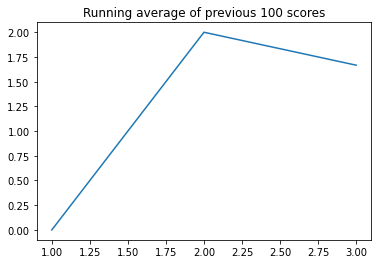

In [45]:
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, filename)